In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import time as time
import pyarrow as pa
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
import dask
import gc
import cartopy
import cartopy.crs as ccrs
import bottleneck
import haversine as hs
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import pygad
from multiprocessing import cpu_count
from os import sched_getaffinity
from collections import Counter
from os import sched_getaffinity
from collections import Counter
import csv
from collections import defaultdict
import collections
import scipy.stats

#### Number of Cores Available

In [2]:
n_cores = cpu_count()
print(f'Number of Logical CPU cores: {n_cores}')
n_available_cores = len(sched_getaffinity(0))
print(f'Number of Available CPU cores: {n_available_cores}')

Number of Logical CPU cores: 64
Number of Available CPU cores: 60


#  Adding Depth Data to Fitness Function Initialisation

## Creating Fitness function

In [3]:
#importing dataset
paths = ['./data/netcdf/80m_full_file.nc']
ds = xr.open_mfdataset(paths, parallel=False,concat_dim='time', data_vars='minimal',combine='nested',
                       coords='minimal',compat='override').compute().load()
ds_mean = ds.mean(dim='time')['wind_mag'].transpose().compute().load() #finding averages
ds_distances = xr.open_mfdataset("./data/netcdf/UK_coast_distances.nc").compute()
ds_sum = ds.sum(dim='time')
paths = ['./data/depth_map.nc'] #importing depth dataset
ds_depth = xr.open_mfdataset(paths,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override').compute()

#implement a preloading of summed data for total figures

grdpnt_power = 30*30*6
turbine_rating = 8 #MW
n_turbs_grdpnt = grdpnt_power/turbine_rating
loss_factor = 0.9 #energy lost due to wind turbines in farms


#correlation function definition
def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True)) * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)
def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))
def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)
def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc,
        x,
        y,
        input_core_dims=[[dim], [dim]],
        dask="parallelized",
        output_dtypes=[float])

In [4]:
def open_wind_farm_csv(location):
    """Opens the wind farm csv and outputs a dictionary of locations."""
    columns = defaultdict(list) # each value in each column is appended to a list
    with open(location) as f:
        reader = csv.DictReader(f) # read rows into a dictionary format
        for row in reader: # read a row as {column1: value1, column2: value2,...}
            for (k,v) in row.items(): # go over each column name and value 
                columns[k].append(v) # append the value into the appropriate list
                                     # based on column name k
    coords = dict()
    coords['Latitude'] = np.array(list(map(float, columns['Latitude'][:19])))
    coords['Longitude'] = np.array(list(map(float, columns['Longitude'][:19])))
    return coords

def fitness_func_depth(coord_idx, solution_idx):
    """Fitness function to evaluate the validity of set of wind farm locations."""
    
#     #convert indexes to locations
#     lat_idx = coord_idx%55
#     lat_idx = lat_idx.astype(int)
#     lon_idx = (coord_idx-lat_idx)/55
#     lon_idx = lon_idx.astype(int)
#     lats_init = xr.DataArray(np.arange(49,63.0,0.25)[lat_idx], dims='coords')
#     lons_init = xr.DataArray(np.arange(-12.5,7.5,0.25)[lon_idx], dims='coords') 
#     coord_sol = np.hstack((lats_init,lons_init))

    coord_sol = coord_idx #replacing above
    num_farms = int(coord_sol.shape[0]/2) #set number of farms
    lats_init = xr.DataArray(coord_sol[:num_farms], dims='coords')
    lons_init = xr.DataArray(coord_sol[num_farms:], dims='coords')
    
    
    ##depth##
    farm_depths = ds_depth.sel(lat = lats_init, lon = lons_init,method="nearest", tolerance=0.1)
    farm_depth_arr = farm_depths.where((farm_depths<0),drop=True).to_array().to_numpy()[0]
    depth_factor = (1 + np.sum(farm_depth_arr)/(180*num_farms)) #comes from 50% increased cost at 60m below sea level
    if np.isnan(depth_factor).all():
        depth_factor = 1
    
    #farm location init.
    num_farms = int(coord_sol.shape[0]/2) #set number of farms
    lats = xr.DataArray(coord_sol[:num_farms], dims='coords')
    lons = xr.DataArray(coord_sol[num_farms:], dims='coords')
    #give an array of True, False Values for onshore
    onshore = (ds_mean.sel(latitude = lats, longitude = lons) < 7.6) #checks if the coords are onshore
    
    num_onshore_farms = onshore.sum().item() #number of onshore farm 
    agg_power = ((ds['power']
                     .sel(latitude = lats, longitude = lons)*n_turbs_grdpnt*loss_factor)
                     .sum(dim='coords')).compute()
    
    #capacity factor (time averaged power factor)
    num_yrs = 24 #years
    total_capacity = 8000 * n_turbs_grdpnt * num_farms #kW
    total_output = agg_power.sum()
    avg_output = total_output / (num_yrs * 24*365.25)
    capacity_factor = avg_output.item()/total_capacity
    
    #loss factor for offshore farms
    offshore = np.logical_not(onshore)
    farm_distances = ds_distances.sel(latitude = lats, longitude = lons)
    offshore_dists = farm_distances.where(offshore)
    offshore_dists_far = offshore_dists.where(offshore_dists > 50)
    num_far_offshore_farms = offshore_dists_far.count().to_array().to_numpy()[0]
    offshore_cable_loss = (offshore_dists_far/1000)*0.035 #cable loss
    offshore_loss_avg = 1 - ((offshore_cable_loss.sum().to_array().to_numpy()[0]+0.014*num_far_offshore_farms)
                         /(num_farms)) #avg loss, converts to % and adds conversion loss

    #correlation init.
    combinations = int(num_farms*(num_farms-1)/2)
    ranks = xr.DataArray(np.zeros((combinations)))
    distances = np.zeros(combinations)

    #firm capacity init.
    ratios = np.array([0.3,0.4,0.5])
    power_limit = ratios * 8000 * n_turbs_grdpnt * num_farms
    firm_capacity = np.empty((ratios.shape[0]))
    unavailable_prop = np.empty((ratios.shape[0]))
    arr_length = agg_power.shape[0]

    #unavailable init.
    num_yrs = 24 #years
    store = dict()
    store_hours = dict()
    storage_limit = 50 #GWh
    store_above_limit = dict()

    for i in range(power_limit.shape[0]):

#         ##unavailable##
#         store[i] = []
#         store_hours[i] = []
#         working_ds = agg_power.copy() - power_limit[i]  
#         working_ds = working_ds.where(working_ds < 0,0).values
#         count = 0 
#         num_hours = 0
#         #sums the groups
#         for j in working_ds:
#             if j.item() == 0:
#                 if count != 0:
#                     store[i].append(count)
#                     store_hours[i].append(num_hours)
#                     count = 0
#                     num_hours = 0
#             else:
#                 count += j.item()
#                 num_hours += 1
#         if count != 0:
#             store[i].append(count)
#             store_hours[i].append(num_hours)
#         store[i] = np.abs(np.array(store[i]))/1e6
#         store_hours[i] = np.sum(np.where(store[i] >= storage_limit,store_hours[i],0))
#         unavailable_prop[i] = store_hours[i]/(8760*24)


        ##firm capacity##
        working_ds = agg_power
        val = working_ds.where(working_ds>=power_limit[i]).count(dim='time').values
        firm_capacity[i] = val/arr_length #proportion of values above the power limit

    ##correlation##           
    count = 0
    #cycle through wind farms
    for i in range(num_farms):
        for j in range(i):
            array1 = ds['power'].sel(latitude = coord_sol[i], longitude = coord_sol[num_farms+i]).compute()
            array2 = ds['power'].sel(latitude = coord_sol[j], longitude = coord_sol[num_farms+j]).compute()
            val = spearman_correlation(array1, array2, 'time')
            ranks[count] = val
            loc1=(coord_sol[i],coord_sol[num_farms+i])
            loc2=(coord_sol[j],coord_sol[num_farms+j])
            distances[count] = hs.haversine(loc1,loc2) 
            count += 1
            del array1
            del array2
    ranks = ranks.to_numpy()
    rank = (np.average(ranks)+1)/2 #0 to 1
    
    #better = larger
    fitness = ((1-rank) * np.average(firm_capacity) * 1.0**num_onshore_farms * offshore_loss_avg
               * capacity_factor * depth_factor)# * (1 - np.average(unavailable_prop)))
    
    decimals = 5
    #print('Unavailable prop:',unavailable_prop[:])
    #print('# Onshore Farms:',num_onshore_farms)
    print('Firm capacity:',np.round(firm_capacity[:],decimals=decimals))
    print('Avg. correlation:',np.round(rank,decimals=decimals))
    print('Offshore loss:',np.round(offshore_loss_avg,decimals=decimals))
    print('Capacity factor:',np.round(capacity_factor,decimals=decimals))
    print('Depth factor:',np.round(depth_factor,decimals=decimals))
    print('Fitness:',np.round(fitness,decimals=decimals))
    
    
    return fitness

def index_conv(coord_idx):
    """Converts indices of the coordinates grid to a 1d array of locations where latitudes are in the first
    half and longitudes in the second."""
    
    lat_idx = coord_idx%55
    lat_idx = lat_idx.astype(int)
    lon_idx = (coord_idx-lat_idx)/55
    lon_idx = lon_idx.astype(int)
    lats_init = xr.DataArray(np.arange(49,63.0,0.25)[lat_idx], dims='coords')
    lons_init = xr.DataArray(np.arange(-12.5,7.5,0.25)[lon_idx], dims='coords') 
    coord_sol = np.hstack((lats_init,lons_init))
    
    return coord_sol

## Testing Fitness Function

In [5]:
indexes = np.round(np.random.rand(30)*18,decimals=0)
indexes = np.array([2, 11, 16, 17, 11, 13,  6, 11, 11,  4,  4, 13,  6, 10,  8,  7, 15, 17,
 14,  7,  1, 14, 16,  1,  1,  8, 17, 13, 11,  1])

#Group 0
coords = np.empty((4,5,2))
coords[0,0,:] = np.array([55, 2.0])
coords[0,1,:] = np.array([54.5, -4.3])
coords[0,2,:] = np.array([50.4, -1.3])
coords[0,3,:] = np.array([58.0, -6.0])
coords[0,4,:] = np.array([51.8, 1.5])

#Group 1
lat = 55
lon = 2.0
coords[1,0,:] = np.array([lat+0.25, lon])
coords[1,1,:] = np.array([lat, lon+0.25])
coords[1,2,:] = np.array([lat, lon-0.25])
coords[1,3,:] = np.array([lat+0.25, lon-0.25])
coords[1,4,:] = np.array([lat+0.25, lon+0.25])

#Group 2
lat = 50.4
lon = -1.3
coords[2,0,:] = np.array([lat+0.25, lon])
coords[2,1,:] = np.array([lat, lon+0.25])
coords[2,2,:] = np.array([lat, lon-0.25])
coords[2,3,:] = np.array([lat+0.25, lon-0.25])
coords[2,4,:] = np.array([lat+0.25, lon+0.25])

#Group 4
coords[3,0,:] = np.array([51., -2.5])
coords[3,1,:] = np.array([53., -4.])
coords[3,2,:] = np.array([54.75, -1.])
coords[3,3,:] = np.array([52., 0.])
coords[3,4,:] = np.array([57., -4.])

coords = (np.round(coords*4, decimals=0)/4)

i = 0
coords_set = np.hstack((coords[i,:,0],coords[i,:,1]))

In [6]:
for i in range(coords.shape[0]):
    print('Group:',i)
    start = time.time()
    coords_set = np.hstack((coords[i,:,0],coords[i,:,1]))
    fitness_func_depth(coords_set,1)
    end = time.time()
    print('Total Time taken:',np.round(end-start,decimals=2),'secs \n')

Group: 0
Firm capacity: [0.789   0.66463 0.53287]
Avg. correlation: 0.68669
Offshore loss: 0.99604
Capacity factor: 0.52492
Depth factor: 0.80889
Fitness: 0.08774
Total Time taken: 0.53 secs 

Group: 1
Firm capacity: [0.68793 0.63064 0.57975]
Avg. correlation: 0.99053
Offshore loss: 0.97983
Capacity factor: 0.56106
Depth factor: 0.82556
Fitness: 0.00272
Total Time taken: 0.5 secs 

Group: 2
Firm capacity: [0.58099 0.50742 0.44573]
Avg. correlation: 0.98632
Offshore loss: 1.0
Capacity factor: 0.45425
Depth factor: 0.92
Fitness: 0.00292
Total Time taken: 0.54 secs 

Group: 3
Firm capacity: [0.49578 0.38416 0.28823]
Avg. correlation: 0.77781
Offshore loss: 1.0
Capacity factor: 0.35135
Depth factor: 0.94778
Fitness: 0.02881
Total Time taken: 0.56 secs 



## Testing Depth Array

Showing depth data can be useful by plotting values.

In [7]:
lats_init = xr.DataArray(np.arange(49,63.0,0.25), dims='coords').to_numpy()
lons_init = xr.DataArray(np.arange(-12.5,7.5,0.25), dims='coords') .to_numpy()

arr_len = lats_init.shape[0] * lons_init.shape[0]
tot_coord_arr = np.zeros((2,arr_len))
count = 0
for i, lat in enumerate(lats_init):
    for j, lon in enumerate(lons_init):
        tot_coord_arr[:,count] = [lat,lon]
        count += 1
lats_xr = xr.DataArray(tot_coord_arr[0,:], dims='coords')
lons_xr = xr.DataArray(tot_coord_arr[1,:], dims='coords')

#creating array of coordinates with elevation < 0m
farm_depths = ds_depth.sel(lat = lats_xr, lon = lons_xr,method="nearest", tolerance=0.1)
farm_depth_arr = farm_depths.to_array().to_numpy()[0]
farm_depth_true = np.where((farm_depth_arr < 0) & (farm_depth_arr > -60),True,False) #height params for incl. farms
farm_depth_spec = farm_depth_arr[farm_depth_true]
tot_coord_spec = tot_coord_arr[:,farm_depth_true]
print(tot_coord_spec)

[[49.   49.   49.   ... 62.75 62.75 62.75]
 [-3.   -2.75 -2.5  ...  6.25  6.5   6.75]]


In [25]:
ocean_depths = farm_depths.where(farm_depths)
print(farm_depths.transpose())#.to_array().values)


<xarray.Dataset>
Dimensions:    (coords: 4480)
Coordinates:
    lat        (coords) float64 49.0 49.0 49.0 49.0 ... 62.75 62.75 62.75 62.75
    lon        (coords) float64 -12.5 -12.25 -12.0 -11.75 ... 6.752 7.002 7.248
Dimensions without coordinates: coords
Data variables:
    elevation  (coords) int16 -1411 -1175 -1055 -1360 -1259 ... -26 -31 253 45
Attributes: (12/36)
    title:                           The GEBCO_2022 Grid - a continuous terra...
    summary:                         The GEBCO_2022 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/e0f0bb80-ab44-2739-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi

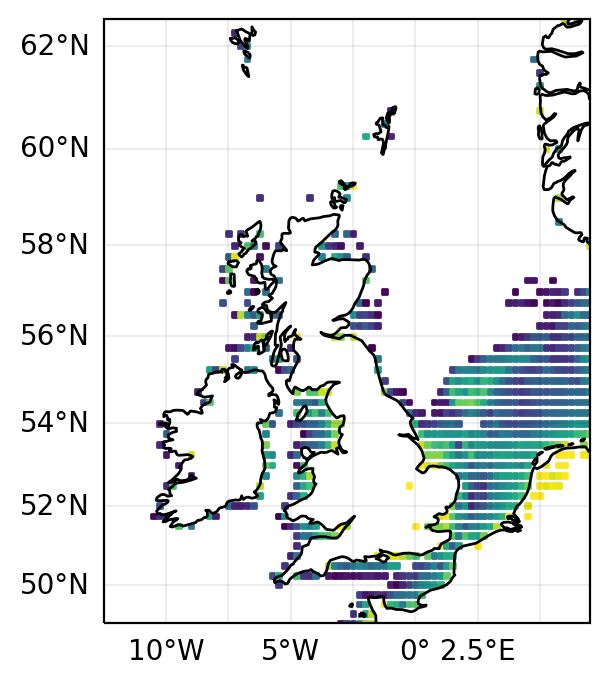

In [26]:


edge =-0.05

#plotting
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator()), dpi=200)
ax = plt.axes(projection=ccrs.Mercator())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='black', alpha=0.5 )
gl.top_labels = False
gl.right_labels = False
plt.title('Wind Farm Locations')
plt.title('')
ax.set_extent([ds.coords['longitude'][0], ds.coords['longitude'][-1],ds.coords['latitude'][0], ds.coords['latitude'][-1]], ccrs.PlateCarree())
ax.coastlines(resolution='50m')

img_extent = ([ds.coords['longitude'][0], ds.coords['longitude'][-1],ds.coords['latitude'][0]-edge, ds.coords['latitude'][-1]+edge])


plt.scatter(tot_coord_spec[1,:],tot_coord_spec[0,:],marker='s', s=3,transform=ccrs.PlateCarree(),linewidth=1,c =farm_depth_spec ) 
#z = ax.imshow(farm_depths.to_array(), origin='lower', extent=img_extent, transform = ccrs.PlateCarree())

divider = make_axes_locatable(ax)

# Running GA

Gene space denotes the indexes that have an elevation above -60m. Coordinate grid is indexed from top left to bottom right.

In [9]:
fitness_function = fitness_func_depth

num_generations = 10
num_parents_mating = 2

sol_per_pop = 5 #num different groups that can be chosen (# chromosomes)
num_genes = 5 #num of farms per group (# genes per chromosome)

#creating gene space of indexes with depths > -60m
gene_space_all=np.arange(0,4345)
lat_idx = gene_space%55
lat_idx = lat_idx.astype(int)
lon_idx = (gene_space-lat_idx)/55
lon_idx = lon_idx.astype(int)
lats = np.arange(49,63.0,0.25)[lat_idx]
lons = np.arange(-12.5,7.5,0.25)[lon_idx]
lats_xr = xr.DataArray(lats, dims='coords')
lons_xr = xr.DataArray(lons, dims='coords')
farm_depth = ds_depth.sel(lat = lats_xr, lon = lons_xr,method="nearest", tolerance=0.1)
farm_depth_arr = farm_depth.to_array().to_numpy()
farm_depth_arr = np.where((farm_depth_arr<-60),False,True)
gene_space = gene_space_all[farm_depth_arr[0]]
print(gene_space)

parent_selection_type = "rank"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "adaptive"
mutation_percent_genes = [30,10]

def callback_gen(ga_instance):
    print("Generation : ", ga_instance.generations_completed)
    print("Fitness of the best solution :", ga_instance.best_solution()[1])

last_fitness = 0
start_step = time.time()
def on_generation(ga_instance):
    global last_fitness
    global start_step
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness))
    end = time.time()
    print('Time taken:',np.round(end-start_step,decimals=3),'secs \n')
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]
    start_step = time.time()

NameError: name 'gene_space' is not defined

In [ ]:
ga_instance = pygad.GA(num_generations=num_generations,
                       gene_space = gene_space,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       on_generation=on_generation,
                       parallel_processing=["process",sol_per_pop])
                       

In [138]:
start = time.time()
ga_instance.run()
end = time.time()
print('Time taken:',np.round(end-start,decimals=3))

/home/xzcaphbe/.conda/envs/env3.8_optimise/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/xzcaphbe/.conda/envs/env3.8_optimise/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Generation = 1
Fitness    = 0.06766789684502213
Change     = 0.06766789684502213
Time taken: 7.105 secs 

Generation = 2
Fitness    = 0.0758527295073026
Change     = 0.00818483266228047
Time taken: 4.647 secs 

Generation = 3
Fitness    = 0.09091367162795796
Change     = 0.015060942120655368
Time taken: 4.438 secs 

Generation = 4
Fitness    = 0.09113616270346828
Change     = 0.00022249107551031155
Time taken: 4.319 secs 

Generation = 5
Fitness    = 0.09801482624232262
Change     = 0.006878663538854343
Time taken: 4.285 secs 

Generation = 6
Fitness    = 0.09801482624232262
Change     = 0.0
Time taken: 4.254 secs 

Generation = 7
Fitness    = 0.09801482624232262
Change     = 0.0
Time taken: 4.199 secs 

Generation = 8
Fitness    = 0.09801482624232262
Change     = 0.0
Time taken: 4.207 secs 

Generation = 9
Fitness    = 0.09801482624232262
Change     = 0.0
Time taken: 4.663 secs 

Generation = 10
Fitness    = 0.09801482624232262
Change     = 0.0
Time taken: 4.451 secs 

Time taken: 45.

Parameters of the best solution : [1245. 3646. 3902. 3380.  451.]
Fitness value of the best solution = 0.09801482624232262


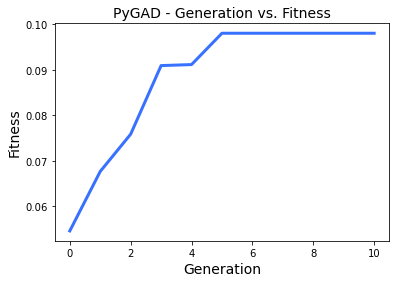

Figure(432x288)


In [139]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print(ga_instance.plot_fitness())

## Plotting Multiple Runs

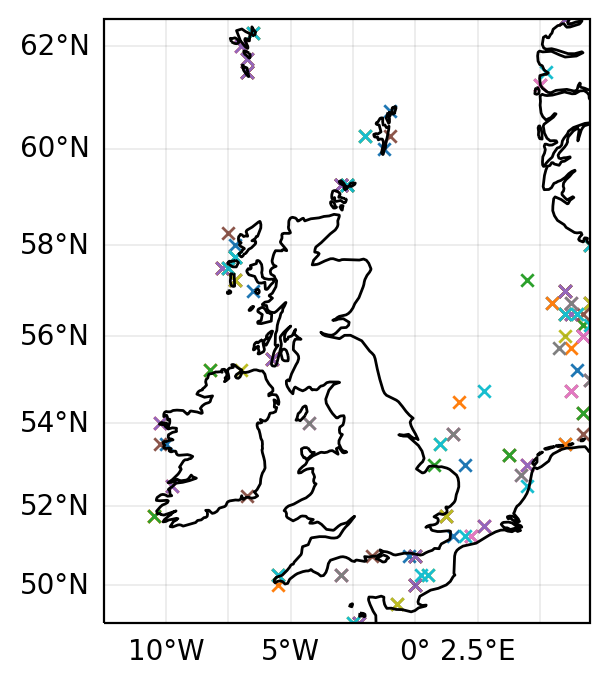

In [7]:
#loading locations
farm_locations = dict()
coord_sol = dict()
for i in range(10):
    farm_locations[i] = np.loadtxt(f'./data/farm_locations/locs_depth{i}')
    lat_idx = farm_locations[i]%55
    lat_idx = lat_idx.astype(int)
    lon_idx = (farm_locations[i]-lat_idx)/55
    lon_idx = lon_idx.astype(int)
    lats = np.arange(49,63.0,0.25)[lat_idx]
    lons = np.arange(-12.5,7.5,0.25)[lon_idx]
    coord_sol[i] = np.hstack((lats,lons))

num_farms = int(coord_sol[i].shape[0]/2)
edge =-0.05

#plotting
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator()), dpi=200)
ax = plt.axes(projection=ccrs.Mercator())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='black', alpha=0.5 )
gl.top_labels = False
gl.right_labels = False
plt.title('Wind Farm Locations')
plt.title('')
ax.set_extent([ds.coords['longitude'][0], ds.coords['longitude'][-1],ds.coords['latitude'][0], ds.coords['latitude'][-1]], ccrs.PlateCarree())
ax.coastlines(resolution='50m')

img_extent = ([ds.coords['longitude'][0], ds.coords['longitude'][-1],ds.coords['latitude'][0]-edge, ds.coords['latitude'][-1]+edge])

for i in range(10):
    plt.scatter(x=coord_sol[i][num_farms:], y=coord_sol[i][:num_farms],marker='x', s=20,transform=ccrs.PlateCarree(),linewidth=1)#fitness_arr) 


divider = make_axes_locatable(ax)

plt.savefig('./figures/all_locations_optimisation.pdf',bbox_inches='tight')

## Identifying Wind Farm Locations < 60m Depth

This is to identify exemplary locations that can be used for the evaluation of statistical methods.


In [41]:
## DEFINE GROUP COORDINATES ##

#Group 0
coords = np.empty((4,5,2))
coords[0,0,:] = np.array([55, 2.0])
coords[0,1,:] = np.array([54.5, -4.3])
coords[0,2,:] = np.array([50.4, -1.3])
coords[0,3,:] = np.array([58.0, -6.0])
coords[0,4,:] = np.array([51.8, 1.5])

#Group 1
lat = 55
lon = 2.0
coords[1,0,:] = np.array([lat+0.25, lon])
coords[1,1,:] = np.array([lat, lon+0.25])
coords[1,2,:] = np.array([lat, lon-0.25])
coords[1,3,:] = np.array([lat+0.25, lon-0.25])
coords[1,4,:] = np.array([lat+0.25, lon+0.25])

#Group 2
lat = 50.4
lon = -1.3
coords[2,0,:] = np.array([lat+0.25, lon])
coords[2,1,:] = np.array([lat, lon+0.25])
coords[2,2,:] = np.array([lat, lon-0.25])
coords[2,3,:] = np.array([lat+0.25, lon-0.25])
coords[2,4,:] = np.array([lat+0.25, lon+0.25])

#Group 4
coords[3,0,:] = np.array([51., -2.5])
coords[3,1,:] = np.array([53., -4.])
coords[3,2,:] = np.array([54.75, -1.])
coords[3,3,:] = np.array([52., 0.])
coords[3,4,:] = np.array([57., -4.])

coords = (np.round(coords*4, decimals=0)/4)
print(coords)

#placing into 1D arrays
lats = np.hstack((coords[0,:,0],coords[1,:,0],coords[2,:,0],coords[3,:,0]))
lons = np.hstack((coords[0,:,1],coords[1,:,1],coords[2,:,1],coords[3,:,1]))
lats_init = xr.DataArray(lats, dims='coords')
lons_init = xr.DataArray(lons, dims='coords') 

[[[55.    2.  ]
  [54.5  -4.25]
  [50.5  -1.25]
  [58.   -6.  ]
  [51.75  1.5 ]]

 [[55.25  2.  ]
  [55.    2.25]
  [55.    1.75]
  [55.25  1.75]
  [55.25  2.25]]

 [[50.75 -1.25]
  [50.5  -1.  ]
  [50.5  -1.5 ]
  [50.75 -1.5 ]
  [50.75 -1.  ]]

 [[51.   -2.5 ]
  [53.   -4.  ]
  [54.75 -1.  ]
  [52.    0.  ]
  [57.   -4.  ]]]


In [42]:
##depth##
farm_depths = ds_depth.sel(lat = lats_init, lon = lons_init,method="nearest", tolerance=0.1)

In [43]:
farm_depths.where(farm_depths<-60)

<xarray.Dataset>
Dimensions:    (coords: 20)
Coordinates:
    lat        (coords) float64 55.0 54.5 50.5 58.0 ... 53.0 54.75 52.0 57.0
    lon        (coords) float64 2.002 -4.248 -1.248 ... -0.9979 0.002083 -3.998
Dimensions without coordinates: coords
Data variables:
    elevation  (coords) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/36)
    title:                           The GEBCO_2022 Grid - a continuous terra...
    summary:                         The GEBCO_2022 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/e0f0bb80-ab44-2739-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/e0f0bb80-ab44-2739-e053-6c8...
    references:                      DOI: 10.5285/e0f0bb80-ab44-2739-e053-6c8...
    node_offset:                     1.0